#                                    Image Classification - Rupantar Rana

In this project, we will try to classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of 50000 train and 10000 test images all of dimension 32x32 of airplanes, dogs, cats, and other objects. We will preprocess the images, then train various model including knn, svm , softmax classifier, two layer neural network and finally convolutional neural network on all the samples. 
Our objective at the end of the project is to be able to build and compare various machine learning models. 

The images need to be normalized and the labels need to be one-hot encoded.  We will also be applying some of the concepts in deep learning such as convolutional, max pooling, dropout, and fully connected layers.  

## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [264]:
import numpy as np
import pickle
import os


from sklearn.preprocessing import LabelBinarizer
data_path = "./data/cifar-10-batches-py/"

########################################################################

### Specify the width and the height of each image
img_size = 32
num_channels = 3 #(RGB)
img_flatten_dim = img_size * img_size * num_channels

### Number of class labels 
num_classes = 10

### Number of training batches and images in each training batch
num_training_batches = 5
num_of_images_per_file = 10000

### Total number of training images 
num_training_images = num_training_batches * num_of_images_per_file

########################################################################

def get_path(filename):
    """
    Returns the full path of the file. File in this case would be the of the
    format data_batch_*
    """
    return os.path.join(data_path,filename)
    

def cifar_unpickle(filename=""):
    """
    Returns : The raw pixels and the associated labels.
    Unpickle the given file and return the raw training images and their labels. 
    """
    print("Loading data from file:" + filename)

    import cPickle
    file_path = get_path(filename)
    
    with open(file_path,mode = 'rb') as file:
        dataset = pickle.load(file)
        X = dataset['data']
        Y = dataset['labels']
    
    return X,Y

def format_images(image):
    """
    Input  : Raw Flattened image
    Output : 4 dimensional numpy array 
    The images in Cifar 10 dataset are flattened , we need to reshape it 
    to a 4-dim array with shape: [image_number,height,width,channel(RGB)]
    """
    
    #Mean normalization : This is done so that the pixels have the same scale which makes the gradients and 
    # the weight updates much more robust.
    image_float = np.array(image)
    #image_float = np.array(image,dtype = float)/255.0
    
    #Reshaping to a 4 dim array
    images = image_float.reshape([-1,num_channels,img_size,img_size])
    
    #reorder the axis 
    images = images.transpose([0,2,3,1]).astype("float")
    
    return images

    
def load_data(filename):
    """
    Load a pickled data-file from the CIFAR-10 dataset
    and return the converted images and the class number 
    for each image.
    """
    #Get the data
    X_raw,y_labels = cifar_unpickle(filename)
    
    images = format_images(X_raw)
    
    return images, y_labels

def load_class_names():
    """
    Load the names for the classes in the CIFAR 10 dataset
    Returns a list with the names. Example: name[3] is the name
    associated with class-number 3
    """
    import cPickle

    ### Load the class-names from the pickled file 
    filename = 'batches.meta'
    file_path = get_path(filename)
    
    with open(file_path,mode = 'rb') as file:
        dataset = pickle.load(file)
        Y_labels = dataset['label_names']
    

    #convert from binary strings 
    names = [x.decode('utf-8') for x in Y_labels]
    
    return names 

def load_training_data():
    

    """
    Load all the training-data for the cifar10 dataset
    The dataset is split into 5 data-files which are merged here.
    Returns the images ,class-labels(numbers) and one-hot encoded class-labels
    """
    
    #Pre allocating the memory for the images and the class numbers for efficiency
    
    images = np.zeros(shape=[num_training_images,img_size,img_size,num_channels],dtype = 'float')
    cls = np.zeros(shape=[num_training_images],dtype = 'int')
    OneHotEncoder_y = LabelBinarizer()
    
    #begin index for the loaded files 
    begin = 0
                   
    for i in range(num_training_batches):
        #load the images and the class-numbers from the data-file
        images_batch,cls_batch = load_data(filename='data_batch_'+str(i+1))
    
        #number of images in this batch
        num_images = len(images_batch)
        end = begin + num_images
        
        #store the images into the array 
        images[begin:end,:] = images_batch
        
        #store the class_numbers into a seperate array
        cls[begin:end] = cls_batch
        
        # replace the begin with end for the next batch           
        begin = end
    
    OneHotEncoder_y.fit(cls)
    new_cls = OneHotEncoder_y.transform(cls)

    return images,cls,new_cls                   

def load_test_data():
    """
    Load all the test-data for the cifar-10 datset.
    Returns the images,class-numbers and one hot encoded class_labels
    """
    images,cls = load_data(filename = 'test_batch')
    OneHotEncoder_y = LabelBinarizer()
    OneHotEncoder_y.fit(cls)
    new_class = OneHotEncoder_y.transform(cls)
    return images,np.asarray(cls),new_class
                   

In [265]:
#Load the training dataset of Cifar 10
X_train,y_train,y_train_ohe = load_training_data()

Loading data from file:data_batch_1
Loading data from file:data_batch_2
Loading data from file:data_batch_3
Loading data from file:data_batch_4
Loading data from file:data_batch_5


In [266]:
#Load the testing dataset of Cifar 10
X_test,y_test,y_test_ohe = load_test_data()

Loading data from file:test_batch


In [267]:
print 'Training data shape: ',X_train.shape
print 'Training labels shape: ',y_train_ohe.shape
print 'Test data shape: ',X_test.shape
print 'Test labels shape: ',y_test_ohe.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 10)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 10)


In [268]:
classes = load_class_names()
print classes

[u'airplane', u'automobile', u'bird', u'cat', u'deer', u'dog', u'frog', u'horse', u'ship', u'truck']


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.

In [269]:
from collections import Counter 
Counter(y_train)

Counter({0: 5000,
         1: 5000,
         2: 5000,
         3: 5000,
         4: 5000,
         5: 5000,
         6: 5000,
         7: 5000,
         8: 5000,
         9: 5000})

It looks like we have 5000 examples of each class. If we were to randomly guess the classes of each example our error rate would be around 10%. Let us see if we can design algorithms that can perform better than 10%.

## Implement the K-nearest neighbour algorithm

The Knn classifier:
   * During training, the classifier remembers all the points in the training dataset.
   * Load the classifier from the knn.py file. Knn classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples.
   * Value of k is obtained through cross validation

In [270]:
# Run some setup code for this notebook
import random 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize']  = (10.0,8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
num_classes = len(classes)
print num_classes

10


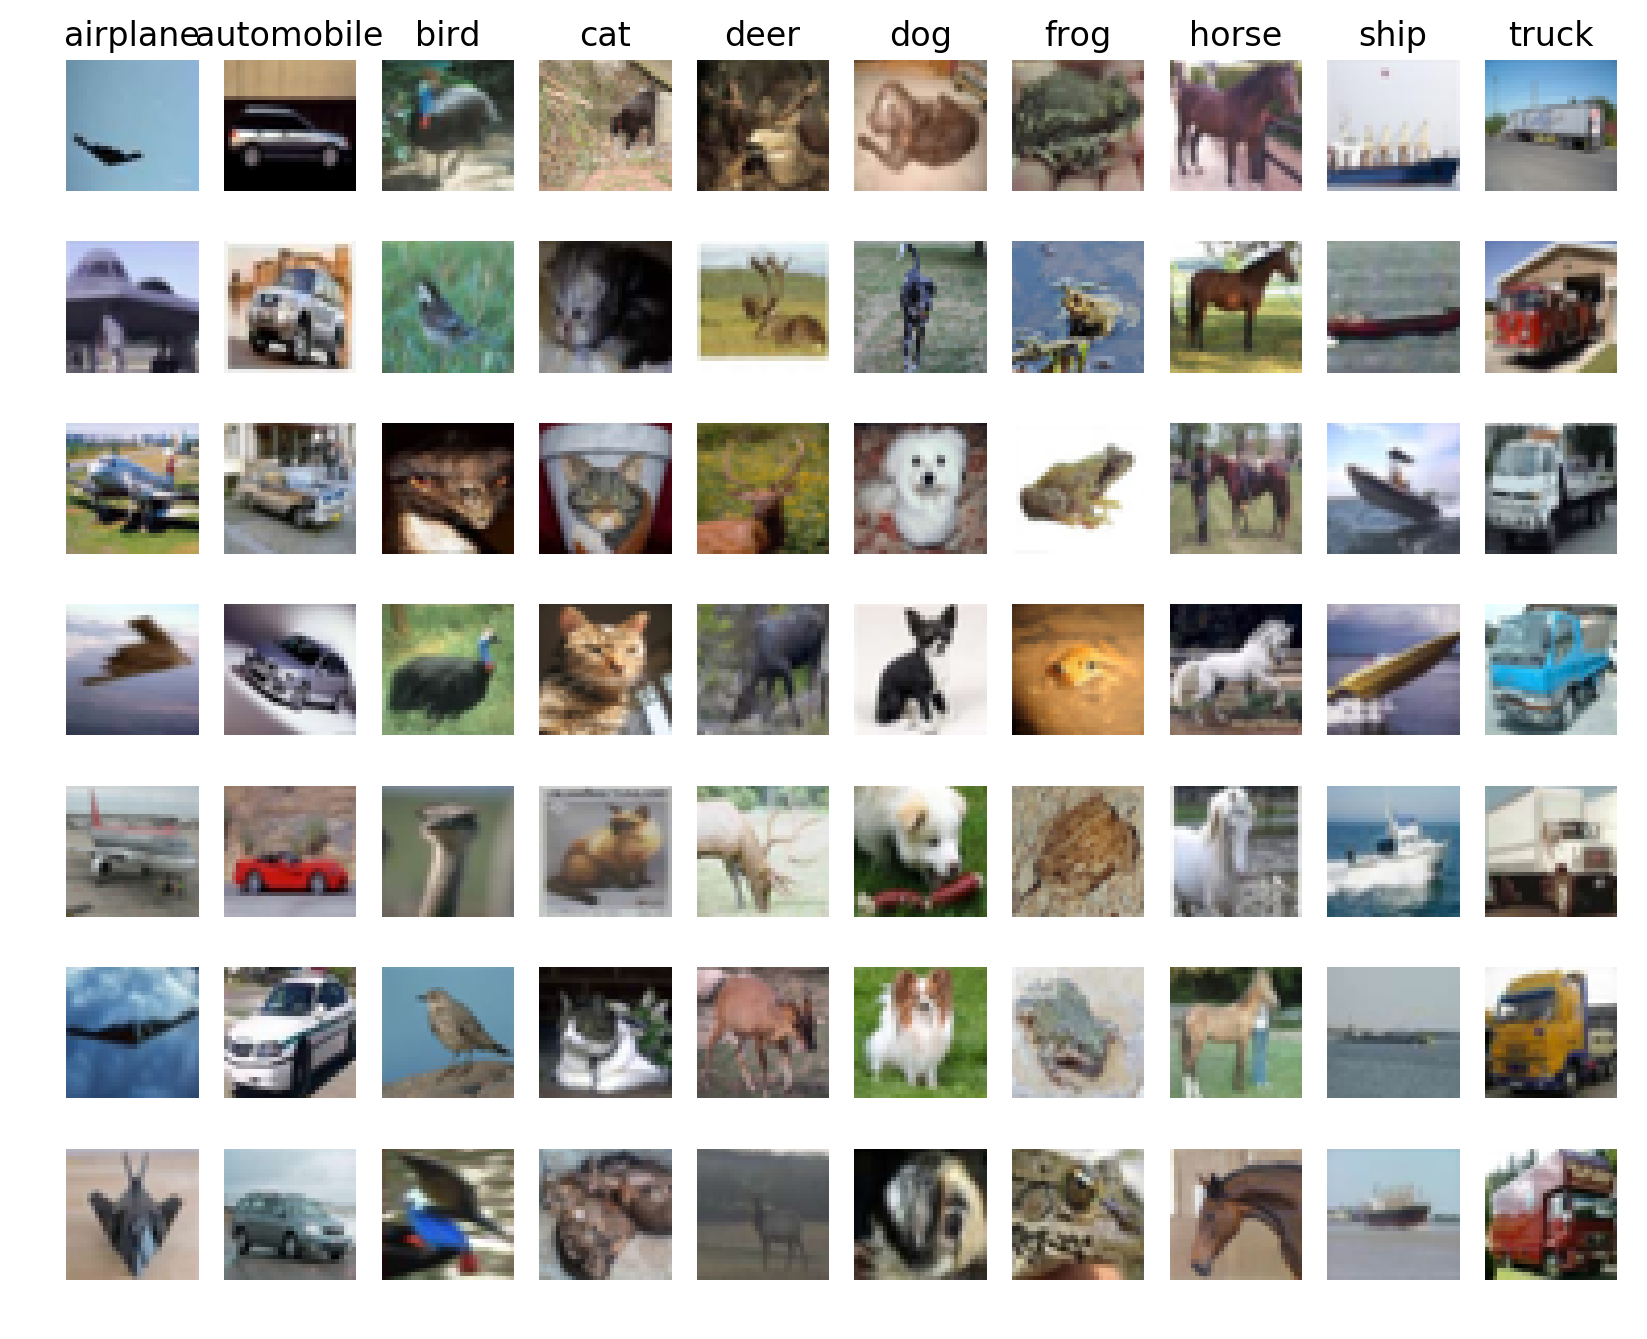

In [272]:
samples_per_class = 7
for y,cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs,samples_per_class,replace = False)
        for i,idx in enumerate(idxs):
            plt_idx = i * num_classes +y +1
            plt.subplot(samples_per_class,num_classes,plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i==0:
                plt.title(cls)
plt.show()

In [273]:
#subsamble the data for more efficient code execution in this exercise 
num_training = 5000
temp = range(num_training)
X_train = X_train[temp]
y_train = y_train[temp]

num_test = 500
temp = range(num_test)
X_test = X_test[temp]
y_test = y_test[temp]

In [274]:
#reshape the image data into rows 
X_train = np.reshape(X_train,(X_train.shape[0],-1))
X_test  = np.reshape(X_test,(X_test.shape[0],-1))

print X_train.shape,X_test.shape

(5000, 3072) (500, 3072)


In [275]:
from knn import KNearestNeighbor

#create a kNN classifier instance
#remember that training a kNN classifier is a noop:
#the classifier simply remembers the data and makes a prediction on the test data
classifier = KNearestNeighbor()
classifier.train(X_train,y_train)

In [276]:
#Test the implementation 
dists = classifier.compute_distance_using_two_loops(X_test)

(500, 5000)


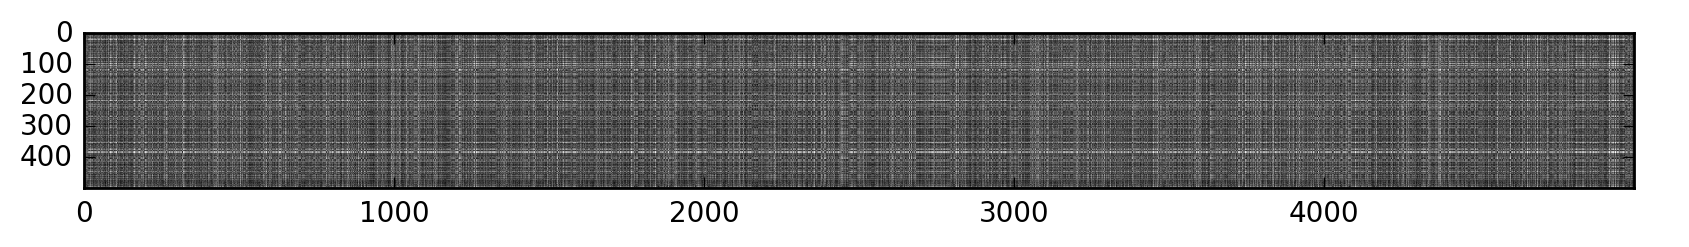

In [277]:
print dists.shape
plt.imshow(dists, interpolation='none')

In [278]:
y_test_predict = classifier.predict_labels(dists,1)

In [279]:
num_correct = np.sum(y_test_predict == y_test)
print num_correct
accuracy = np.mean(y_test_predict == y_test)

137


In [280]:
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 137 / 500 correct => accuracy: 0.274000


Seems pretty good. Accuracy of 27% would be much better considering that the accuracy of choosing a class randomly would be 10%.

### Support Vector Machine Implementation

In [281]:
from svm_loss import svm_loss_half_vectorized

#initialize the weight vector with small weights
W = np.random.randn(3072,10)*0.001
svm_loss_cifar_10 = svm_loss_half_vectorized(W,X_train,y_train,0)
print ("SVM Loss without any weight optimization: %d") %(svm_loss_cifar_10)

SVM Loss without any weight optimization: 25


In [282]:
print X_train.shape

print W.shape

print ("Shape of the output matrix: X.dot(W) %d,%d") % (X_train.shape[0],W.shape[1])

(5000, 3072)
(3072, 10)
Shape of the output matrix: X.dot(W) 5000,10


### Gradient Search 
Below we initialize the weights with small values then update in random direction using a small step size. This will not give us the best result but its a naive implementation of random gradient update. The step size we use here is pretty small to ensure weights do not move around too much. 

In [283]:
#Randomized Gradient search
step_size = 0.001
best_loss  = float("inf")
W = np.random.randn(3072,10)*0.001

for i in xrange(1000):
    W_upd = W + np.random.randn(3072,10)*step_size
    svm_loss = svm_loss_half_vectorized(W_upd,X_train,y_train,0)
    if svm_loss < best_loss: 
         best_loss = svm_loss

    print ("Iteration: %d , Loss : %f") % (i,best_loss)
            
            

Iteration: 0 , Loss : 29.527139
Iteration: 1 , Loss : 29.137264
Iteration: 2 , Loss : 29.137264
Iteration: 3 , Loss : 29.137264
Iteration: 4 , Loss : 29.137264
Iteration: 5 , Loss : 29.137264
Iteration: 6 , Loss : 29.137264
Iteration: 7 , Loss : 29.137264
Iteration: 8 , Loss : 29.137264
Iteration: 9 , Loss : 28.788514
Iteration: 10 , Loss : 27.527074
Iteration: 11 , Loss : 27.527074
Iteration: 12 , Loss : 27.527074
Iteration: 13 , Loss : 27.527074
Iteration: 14 , Loss : 27.527074
Iteration: 15 , Loss : 27.527074
Iteration: 16 , Loss : 27.527074
Iteration: 17 , Loss : 27.527074
Iteration: 18 , Loss : 27.527074
Iteration: 19 , Loss : 27.527074
Iteration: 20 , Loss : 27.527074
Iteration: 21 , Loss : 27.527074
Iteration: 22 , Loss : 27.527074
Iteration: 23 , Loss : 27.527074
Iteration: 24 , Loss : 27.527074
Iteration: 25 , Loss : 26.181574
Iteration: 26 , Loss : 26.181574
Iteration: 27 , Loss : 26.181574
Iteration: 28 , Loss : 26.181574
Iteration: 29 , Loss : 26.181574
Iteration: 30 , Loss

In [284]:
#Analytic Gradient update 
def eval_numerical_gradient(f,x):
    """
    a naive implementation of numerical gradient of f at x 
    -f should be a function that takes a single argument
    -x is the point (numpy array) to evaluate the gradient at
    """
    
    fx = f(x)
    grad = np.zeros(x.shape)
    h=0.001
    
    #iterate over all indexes in x 
    it = np.nditer(x,flags = ['multi_index'],op_flags=['readwrite'])
    
    while not it.finished:
        
        #evaluate function at x+h
        ix = it.multi_index
        old_value = x[ix]
        x[ix] = old_value +h
        fxh = f(x)
        x[ix] = old_value
        
        #compute the partial derivative
        grad[ix] = (fxh-fx)/h
        it.iternext()
    
    return grad

In [285]:
print W.shape,X_train.shape


(3072, 10) (5000, 3072)


In [286]:
X_train.dot(W).shape

(5000, 10)

In [287]:
def cifar_svm_loss(X):
    return svm_loss_half_vectorized(W,X,y_train,0)

#df = eval_numerical_gradient(cifar_svm_loss,X_train)
svm_loss_half_vectorized(W,X_train,y_train,0)

23.593050118798498

In [288]:
#df=eval_numerical_gradient(cifar_svm_loss,X_train)

In [263]:
X = X_train
y = y_ohe
W = 0.01 * np.random.randn(3072,10)
b = np.zeros((1,10))

step_size = 1e-0
reg  = 1e-3

num_examples = X.shape[0]

for i in xrange(200):
    
    scores = np.dot(X,W) + b 
    
    exp_scores = np.exp(scores) 
    
    probs = exp_scores/np.sum(exp_scores,axis=1,keepdims=True)
    
    corect_logprobs = - np.log(probs[range(num_examples),y])
    
    data_loss = np.sum(correct_logprobs)/num_examples
    
    reg_loss = 0.5*reg*np.sum(W*W)
    
    loss = data_loss + reg_loss 
    
    if i % 10 ==0:
        print "iteration %d: loss %f" % (i,loss)
        
    dscores = probs 
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples
    
    
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores)

IndexError: arrays used as indices must be of integer (or boolean) type

In [165]:
## Randomized Gradient search
step_size = 0.00001
best_loss  = float("10000")
W = np.random.randn(3072,10)


for i in xrange(1000):
    W_upd = W - grad*step_size
    cross_entropy_loss ,grad = getLoss(W_upd,X_train,y_train,0.001)
    if cross_entropy_loss < best_loss: 
         best_loss = cross_entropy_loss

    print ("Iteration: %d , Loss : %f") % (i,best_loss)
    print cross_entropy_loss

[[-0.31715661 -0.25127716 -0.65362115 ..., -1.63127763  0.80222284
   0.04798027]
 [-0.65985693 -0.68421505 -0.34709493 ...,  0.80895599  1.43481625
   0.88669242]
 [ 0.12885914 -0.00783165 -2.41910775 ..., -2.50102106 -1.1093936
   0.81287552]
 ..., 
 [-0.68061752 -0.6358851  -0.31151373 ..., -0.10509841  1.46369181
  -0.00686138]
 [ 0.65183743 -0.24172724  0.1605198  ...,  0.42142435  0.37112447
  -0.69007728]
 [-0.29827564 -0.19374843 -0.41917344 ..., -0.26097748  1.39594248
   0.23202876]] [[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


In [100]:
step_size = 0.0001
best_loss  = float("inf")
W = np.random.randn(3072,10)* step_size
#grad = np.zeros(W.shape)

cross_entropy_loss ,grad = getLoss(W,X_train,y_train,0)

W_upd = W - grad * step_size
print W

[[ -3.74708287e-05  -4.75329011e-05   7.88657829e-05 ...,  -1.46113354e-04
    1.20832045e-04   8.46828496e-05]
 [  3.00681771e-05  -2.38485282e-05  -2.44627600e-05 ...,   1.47016843e-04
    6.02237370e-06  -5.41634616e-05]
 [ -4.19613835e-05   7.42104617e-05  -7.14709272e-05 ...,   1.85565251e-04
    7.58561375e-05   1.18561796e-04]
 ..., 
 [  8.20727923e-05  -7.93830562e-05   5.69935796e-05 ...,   4.32807664e-05
    1.28718292e-04   1.39224516e-06]
 [ -5.50732306e-05   1.05064366e-04  -7.63780119e-06 ...,   5.29557442e-05
   -1.71231957e-05   3.95860910e-05]
 [  8.18668506e-05   4.23209641e-05   3.07841403e-05 ...,   4.67447228e-05
   -9.34143724e-05  -1.14401062e-05]]


In [45]:
################ _____CONTINUE________ ################################